In [1]:
#보스턴 부동산 데이터 로드
from sklearn.datasets import load_boston
import pandas as pd
import statsmodels.api as sm

boston = load_boston()

#독립변수 데이터 만들기
dfX0 = pd.DataFrame(boston.data, columns= boston.feature_names)

#독립변수와 종속변수 데이터를 모델에 집어넣기
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target, columns=['MEDV']) #df['종속변수']

model = sm.OLS(dfy, dfX)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          6.72e-135
Time:                        10:25:04   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

[2]번 에러가 뜻하는 것 = 조건수가 너무 크다. 다중공선성 문제나 수치적인 문제가 있을 수 있다.

### 조건수 : 작은 변화의 비율에 대해 함수가 얼마나 변화할 수 있는지 알려주는 수치
### 즉, 우리가 구한 선형회귀식의 x가 얼마나 부정확할지에 대한 범위를 보여준다

조건수가 크면, 작은 오차가 있다고 하더라도 실제 값인 x에서는 큰 오차가 발생할 것이고
조건수가 작으면, 작은 오차가 있어도 오차가 크게 발생하지 않을 것

즉, 공분산행렬의 조건수가 크면 회귀분석을 사용한 예측값도 오차가 커진다

조건수 = 가장 큰 고유치/ 가장 작은 고유치 = 가장 큰 고유치와 가장 작은 고유치의 비율 
고유치 = 어떤 행렬 A가 있다고 할 때, 행렬 A가 선형변환한 결과가 자기 자신을 곱한 배율이 아닌, 0이 되는 행렬을 고유 벡터라고 하는데, 이것의 상수배가 되는 값을 고유치라고 함

#### 해당 문제를 처리하기 위해 스케일링이나 PCA와 같은 차원 축소 방법을 사용한다

In [2]:
#표준 편차를 통한 독립변수의 스케일 확인
dfX.describe().loc['std']

const        0.000000
CRIM         8.601545
ZN          23.322453
INDUS        6.860353
CHAS         0.253994
NOX          0.115878
RM           0.702617
AGE         28.148861
DIS          2.105710
RAD          8.707259
TAX        168.537116
PTRATIO      2.164946
B           91.294864
LSTAT        7.141062
Name: std, dtype: float64

In [5]:
#스케일링
dfX = sm.add_constant(dfX0) #독립변수
dfy = pd.DataFrame(boston.target, columns=['MEDV']) #df['종속변수']

#종속 변수 + 독립변수 = 전체 데이터
df = pd.concat([dfX, dfy], axis = 1)


feature_names = list(boston.feature_names)
feature_names.remove('CHAS')
feature_names = ['scale({})'.format(name) for name in feature_names] + ['CHAS']
model2 = sm.OLS.from_formula("MEDV ~" + '+'.join(feature_names), data=df)

result = model2.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          6.72e-135
Time:                        10:56:10   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         22.3470      0.219    101.

# 문제 있는 부분을 수정하기
- 통계를 해본 결과가 괜찮은지 진단을 해보고, 그것을 수정하기

- 데이터가 만든 모델을 따라간다고 가정하면, 분석결과로 나온 잔차가 정규 분포를 따라간다
- 그런데, 우리가 만든 모델의 잔차가 정규 분포를 따라가지 않는 경우라면? 이를 수정해야한다.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

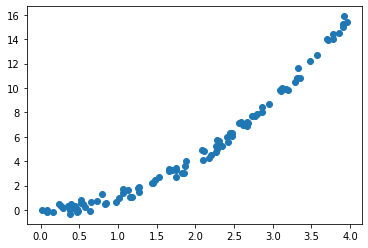

In [8]:
#비선형 함수를 만들기
def make_regression(n = 100, bias = 0, noise = 0.3, random_state = 0):
    np.random.seed(random_state)
    x = np.random.rand(n) * 4
    epsilon = noise * np.random.randn(n) #가우시안 정규 분포를 따라가는 값
    y = x ** 2 + bias + epsilon
    return x, y 

x, y = make_regression()
plt.scatter(x,y)
plt.show()

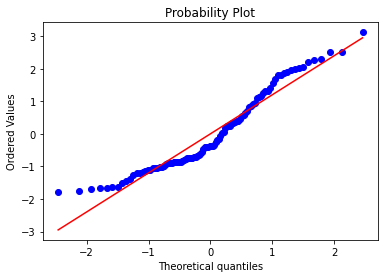

('Chi*2', 9.519843718949735)
('P-value', 0.008566278744865695)


In [18]:
import scipy as sp

dfx1 = pd.DataFrame(x, columns=['x1'])
dfX1 = sm.add_constant(dfx1)
dfy1 = pd.DataFrame(y, columns=['y1'])

model2 = sm.OLS(dfy1, dfX1)
result = model2.fit()

#잔차를 통해 확인하기
sp.stats.probplot(result.resid, plot=plt)
plt.show()

#카이 제곱 검정과 Pvalue를 확인
resid_data = sm.stats.omni_normtest(result.resid)
for i in zip(['Chi*2', 'P-value'],resid_data):
    print(i)

In [20]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1320.
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           1.13e-58
Time:                        11:41:13   Log-Likelihood:                -161.10
No. Observations:                 100   AIC:                             326.2
Df Residuals:                      98   BIC:                             331.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3299      0.235     -9.910      0.0

카이 제곱 검정(Chi*2) - 관찰된 빈도가 기대되는 빈도와 다른지 여부를 검정하기 위해 사용되는 방법
- 어떤 모집단의 표본이, 그 모집단을 대표하고 있는지
- 독립변수가 2개 이상일 때, 두 독립변수가 서로 독립적인지 확인

p-value(유의확률)
- 귀무가설이 맞다고 가정할때, 극단적인 결과가 실제로 관측될 확률
- 이 데이터에 대한 가설이 맞거나 맞지 않거나를 확인할 때 
- 0.005 이하면 유의미하고, 0.05~0.005면 특정 조건에서는 의미가 있다

데이터가 선형이 아닐 경우
- 기존의 선형 회귀 방법으로 해당 데이터를 잘 표현하는 식을 찾는 것은 한계가 있다
- 다중 선형 회귀(선을 여러개를 쓰는)로 전향하거나, 혹은 해당 데이터를 선형으로 만들어서 예측을 한다

### 다중 선형 회귀(선을 여러개를 쓰는)를 쓰는 과정에서 발생하는 문제점
- 알아야하는 이유 : 동일한 문제가 딥러닝과 머신러닝에서 그대로 발생함

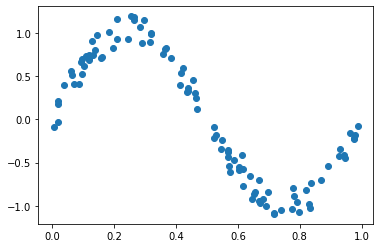

In [21]:
#다중 회귀를 써야하는 상황을 만들기
import numpy as np

def nonlinear(seed = 0):
    np.random.seed(seed)
    n = 100
    X = np.sort(np.random.rand(n))
    y = np.sin(2 * np.pi * X) + np.random.randn(100) * 0.1
    X = X[:, np.newaxis]
    return (X,y)

X, y = nonlinear()

plt.scatter(X,y)
plt.show()

In [23]:
#stats 모델의 단순 선형 회귀인 상황
dfx2 = pd.DataFrame(X, columns=['x1'])
dfX2 = sm.add_constant(dfx2)
dfy2 = pd.DataFrame(y, columns=['y1'])

model3 = sm.OLS(dfy2, dfX2)
result = model3.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     138.3
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           1.93e-20
Time:                        11:56:31   Log-Likelihood:                -64.491
No. Observations:                 100   AIC:                             133.0
Df Residuals:                      98   BIC:                             138.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9322      0.089     10.419      0.0

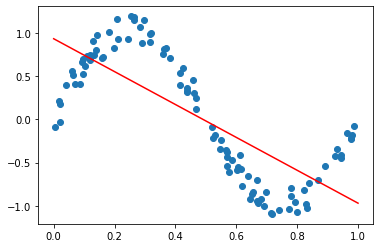

In [37]:
#다중 선형회귀
dfx2 = pd.DataFrame(X, columns=['x'])
dfX2 = sm.add_constant(dfx2)
dfy2 = pd.DataFrame(y, columns=['y'])
df = pd.concat([dfX2, dfy2], axis = 1)

model3 = sm.OLS.from_formula('y ~ x', data=df)
result = model3.fit()
# print(result.summary())

lin_x = np.linspace(0,1,1000)
lin_X = pd.DataFrame(lin_x[:,np.newaxis], columns=['x'])

plt.scatter(X,y)
plt.plot(lin_x, result.predict(lin_X),c= 'r')
plt.show()

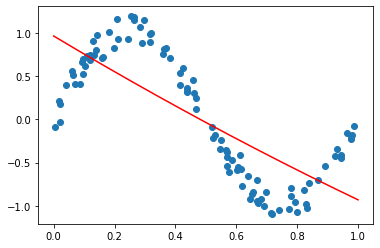

In [38]:
#다중 선형회귀
dfx2 = pd.DataFrame(X, columns=['x'])
dfX2 = sm.add_constant(dfx2)
dfy2 = pd.DataFrame(y, columns=['y'])
df = pd.concat([dfX2, dfy2], axis = 1)

model3 = sm.OLS.from_formula('y ~ x + I(x**2)', data=df)
result = model3.fit()
# print(result.summary())

lin_x = np.linspace(0,1,1000)
lin_X = pd.DataFrame(lin_x[:,np.newaxis], columns=['x'])

plt.scatter(X,y)
plt.plot(lin_x, result.predict(lin_X),c= 'r')
plt.show()

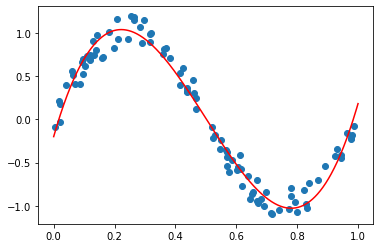

In [33]:
#다중 선형회귀
dfx2 = pd.DataFrame(X, columns=['x'])
dfX2 = sm.add_constant(dfx2)
dfy2 = pd.DataFrame(y, columns=['y'])
df = pd.concat([dfX2, dfy2], axis = 1)

model3 = sm.OLS.from_formula('y ~ x + I(x**2) + I(x**3)', data=df)
result = model3.fit()
# print(result.summary())

lin_x = np.linspace(0,1,1000)
lin_X = pd.DataFrame(lin_x[:,np.newaxis], columns=['x'])

plt.scatter(X,y)
plt.plot(lin_x, result.predict(lin_X),c= 'r')
plt.show()

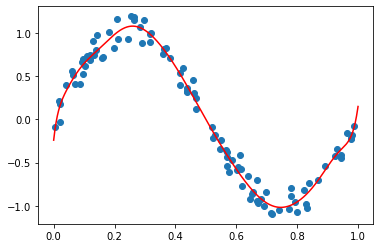

In [58]:
#다중 회귀 분석의 차수를 입력해주는 부분 만들기
# 'y ~ I(x**1) + I(x**2) + I(x**3) + I(x**4)+ I(x**5) + I(x**6)'
degree = 16
string_reg = 'y ~'
for i in range(degree):
    if i == 0:
        plus = ''
    else:
        plus = ' + '
    string_reg += plus + 'I(x**{})'.format(i+1)
    
#다중 선형회귀
dfx2 = pd.DataFrame(X, columns=['x'])
dfX2 = sm.add_constant(dfx2)
dfy2 = pd.DataFrame(y, columns=['y'])
df = pd.concat([dfX2, dfy2], axis = 1)

model3 = sm.OLS.from_formula(string_reg , data=df)
result = model3.fit()
# print(result.summary())

lin_x = np.linspace(0,1,1000)
lin_X = pd.DataFrame(lin_x[:,np.newaxis], columns=['x'])

plt.scatter(X,y)
plt.plot(lin_x, result.predict(lin_X),c= 'r')
plt.show()